In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split,  GridSearchCV, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import os

In [98]:
set = pd.read_csv("../Data/SET_main.csv")
macro = pd.read_csv('../Data/macro_data.csv')

In [99]:
macro= macro.set_index('Date')
set = set.set_index('Date')

In [123]:
set = set.drop(columns= {'TLI.BK'})

In [101]:
macro

,Interest_Rate,GDP,Unemployment,Inflation_x
Date,,,,
2012-10-01,NaN,16420.419,NaN,NaN
2012-12-01,0.16,16420.419,7.9,231.221
2013-01-01,0.14,16648.189,8.0,231.679
2013-02-01,0.15,16648.189,7.7,232.937
2013-03-01,0.14,16648.189,7.5,232.282
...,...,...,...,...
2024-07-01,5.33,29354.321,4.3,313.534
2024-08-01,5.33,29354.321,4.2,314.121
2024-09-01,5.13,29354.321,4.1,314.686


In [125]:
# Loop through each unique ticker (stock) in the DataFrame
indicator = pd.DataFrame()
for ticker in set.columns:
    # Calculate SMAs 
    indicator[f'{ticker}_SMA3'] = set[ticker].rolling(window=3).mean()
    indicator[f'{ticker}_SMA20'] = set[ticker].rolling(window=20).mean()
    indicator[f'{ticker}_SMA50'] = set[ticker].rolling(window=50).mean()
    indicator[f'{ticker}_SMA100'] = set[ticker].rolling(window=100).mean()
    indicator[f'{ticker}_SMA200'] = set[ticker].rolling(window=200).mean()
    
    # Calculate EMA
    indicator[f'{ticker}_EMA3'] = set[ticker].ewm(span=3, adjust=False).mean()
    indicator[f'{ticker}_EMA12'] = set[ticker].ewm(span=12, adjust=False).mean()
    indicator[f'{ticker}_EMA26'] = set[ticker].ewm(span=26, adjust=False).mean()
    
    # Calculate MACD
    indicator[f'{ticker}_MACD'] = indicator[f'{ticker}_EMA12'] - indicator[f'{ticker}_EMA26']
    
    # Calculate Signal line (9-day EMA of the MACD)
    indicator[f'{ticker}_signal'] = indicator[f'{ticker}_MACD'].ewm(span=9, adjust=False).mean()
    
    # Concatenate each ticker's results into the final indicator DataFrame
    indicator = pd.concat([indicator, set], axis=1)

In [130]:
indicator.isnull().sum()[indicator.isnull().sum() !=0].max()

199

In [132]:
indicator = indicator.dropna()

In [134]:
indicator

,ADVANC.BK_SMA3,ADVANC.BK_SMA20,ADVANC.BK_SMA50,ADVANC.BK_SMA100,ADVANC.BK_SMA200,ADVANC.BK_EMA3,ADVANC.BK_EMA12,ADVANC.BK_EMA26,ADVANC.BK_MACD,ADVANC.BK_signal,...,INTUCH.BK,IVL.BK,KBANK.BK,KTB.BK,MINT.BK,PTT.BK,PTTEP.BK,SCC.BK,TRUE.BK,TTB.BK
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-24,147.878474,146.615312,141.166241,140.200967,139.223532,148.335330,147.071694,145.247148,1.824546,1.935432,...,43.067986,18.193783,177.250549,14.698245,28.481108,22.667881,89.475250,309.334839,9.696037,1.923483
2014-10-27,149.838572,146.811322,141.466790,140.218557,139.402898,149.958116,147.765418,145.716315,2.049103,1.958166,...,43.815693,17.962513,178.759064,14.830657,28.481108,22.861076,90.100967,310.760315,9.785814,1.923483
2014-10-28,152.016469,147.301347,141.884944,140.249956,139.574021,152.729607,148.955523,146.441113,2.514409,2.069415,...,43.965233,17.962513,179.513351,15.029284,28.274727,22.861076,89.162415,307.909332,10.324482,1.923483
2014-10-29,153.105418,147.562693,142.237761,140.248686,139.713341,152.481930,149.459943,146.870235,2.589708,2.173473,...,44.114780,18.425062,179.513351,15.095495,28.477810,22.796679,89.788101,309.334839,10.234704,1.910911
2014-10-30,153.758769,147.889375,142.590578,140.260483,139.831349,153.011442,150.087791,147.364362,2.723428,2.283464,...,43.965233,18.425062,175.742035,15.029284,28.477810,22.796679,91.665199,315.036804,10.117992,1.923483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03,289.000000,285.100000,276.820000,258.442008,230.400195,290.694232,286.334304,282.801077,3.533227,3.422761,...,102.500000,24.600000,153.500000,20.299999,27.750000,32.250000,128.500000,184.000000,11.900000,1.790000
2024-12-04,290.333333,285.850000,277.440000,259.166666,230.819507,289.847116,286.744411,283.260256,3.484155,3.435040,...,100.000000,24.500000,155.000000,20.600000,28.000000,32.250000,128.000000,183.000000,12.100000,1.780000
2024-12-06,293.333333,286.350000,278.040000,259.951325,231.268820,292.423558,288.014502,284.129867,3.884635,3.524959,...,102.500000,25.250000,156.000000,20.700001,27.500000,32.250000,128.000000,183.500000,11.800000,1.830000


In [136]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Merge all the files that have X-variable (features)
features_df = pd.merge(macro, indicator, on='Date', how='outer')
features_df = features_df.fillna(method='ffill').dropna()

In [138]:
# drop the same column names
features_df = features_df.loc[:, ~features_df.columns.duplicated()]

In [140]:
# Make the rows number the same with target and features files
# set the index to the format Datetime
set.index = pd.to_datetime(set.index)
features_df.index = pd.to_datetime(features_df.index)

# Align the two DataFrames by finding the intersection of their indices
common_index = set.index.intersection(features_df.index)

# Reindex both DataFrames to the common index
set = set.loc[common_index]
features_df = features_df.loc[common_index]

In [142]:
features_df.shape, set.shape

((2463, 213), (2463, 19))

In [144]:
# define X and y
X = features_df 
y = set 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


Starting prediction for stock: ADVANC.BK
Training set shape for ADVANC.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for ADVANC.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for ADVANC.BK: {'alpha': 0.01}
Performance for ADVANC.BK - RMSE: 2.80


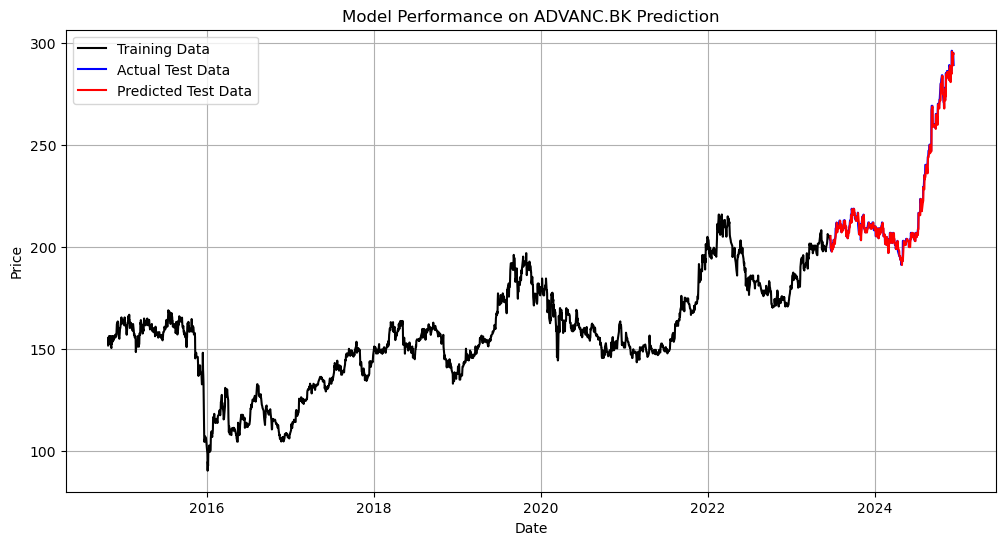


Starting prediction for stock: AOT.BK
Training set shape for AOT.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for AOT.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for AOT.BK: {'alpha': 0.01}
Performance for AOT.BK - RMSE: 0.72


<Figure size 640x480 with 0 Axes>

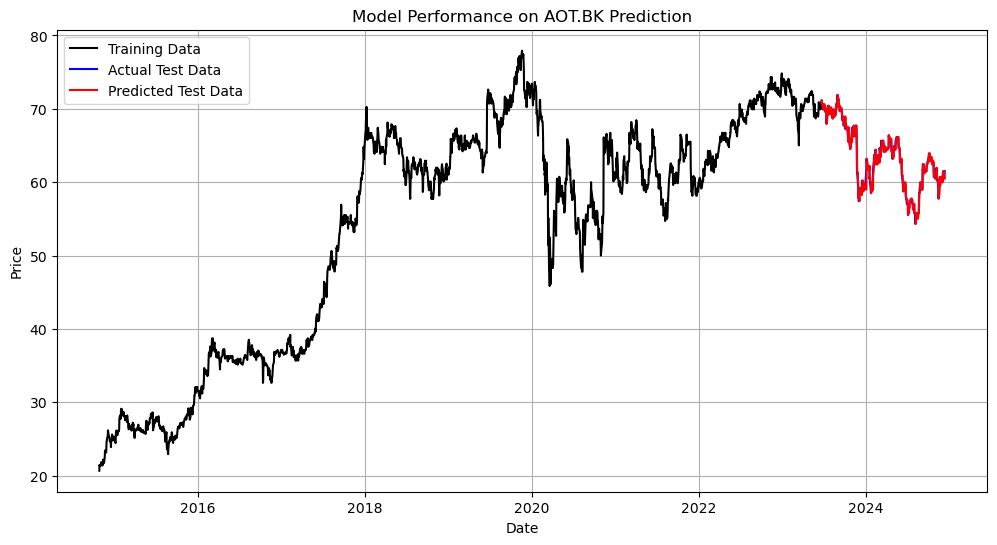


Starting prediction for stock: BBL.BK
Training set shape for BBL.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for BBL.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for BBL.BK: {'alpha': 0.01}
Performance for BBL.BK - RMSE: 1.59


<Figure size 640x480 with 0 Axes>

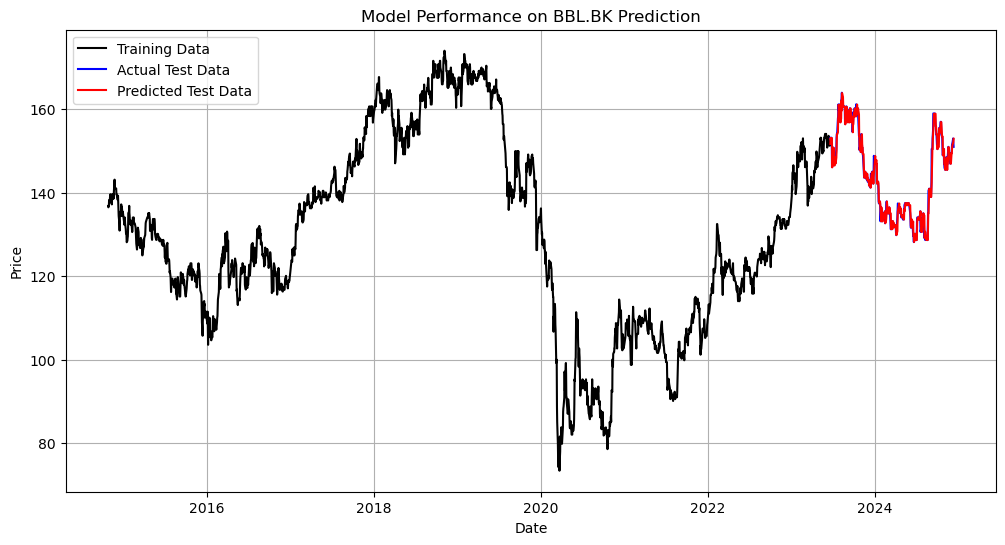


Starting prediction for stock: BDMS.BK
Training set shape for BDMS.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for BDMS.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for BDMS.BK: {'alpha': 0.01}
Performance for BDMS.BK - RMSE: 0.37


<Figure size 640x480 with 0 Axes>

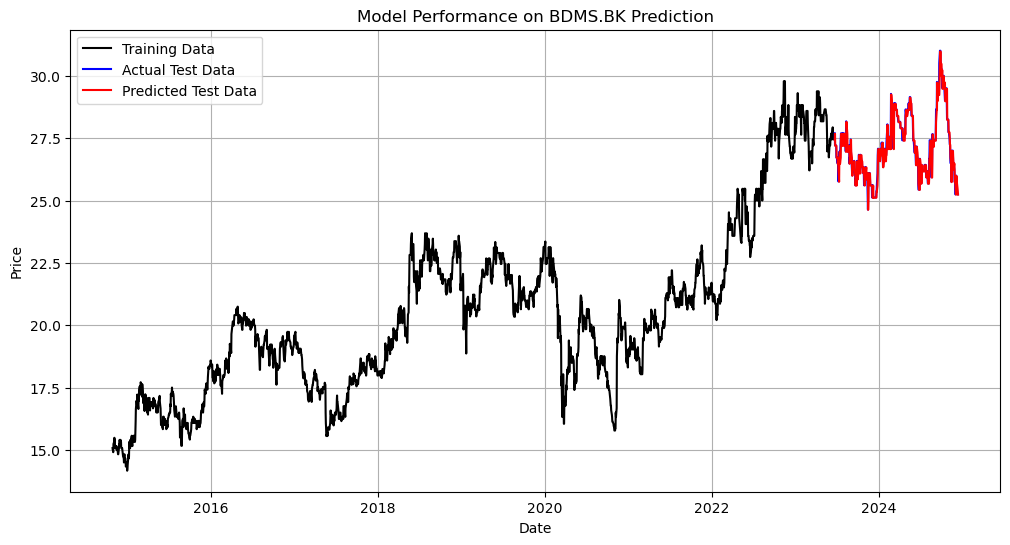


Starting prediction for stock: BH.BK
Training set shape for BH.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for BH.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for BH.BK: {'alpha': 0.01}
Performance for BH.BK - RMSE: 3.98


<Figure size 640x480 with 0 Axes>

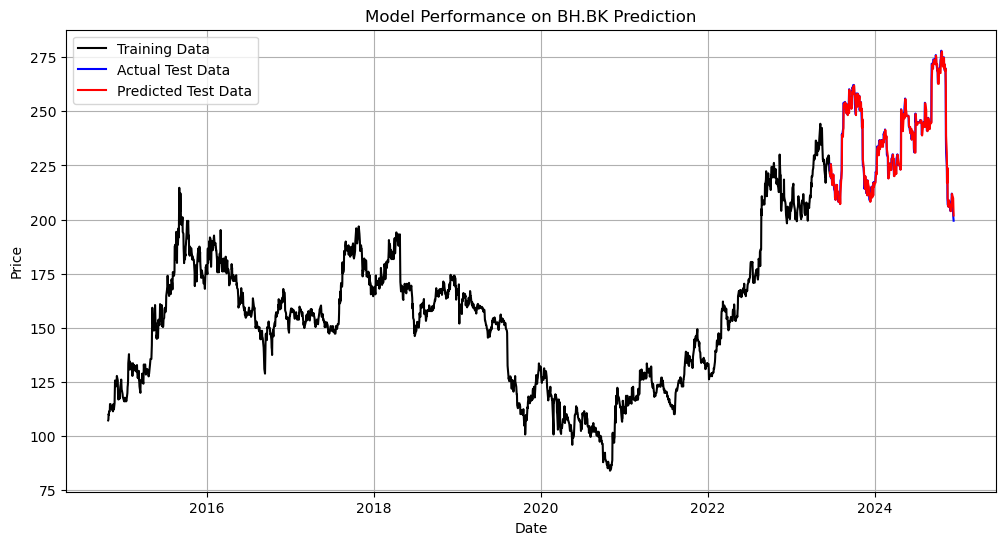


Starting prediction for stock: CPALL.BK
Training set shape for CPALL.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for CPALL.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for CPALL.BK: {'alpha': 0.01}
Performance for CPALL.BK - RMSE: 0.75


<Figure size 640x480 with 0 Axes>

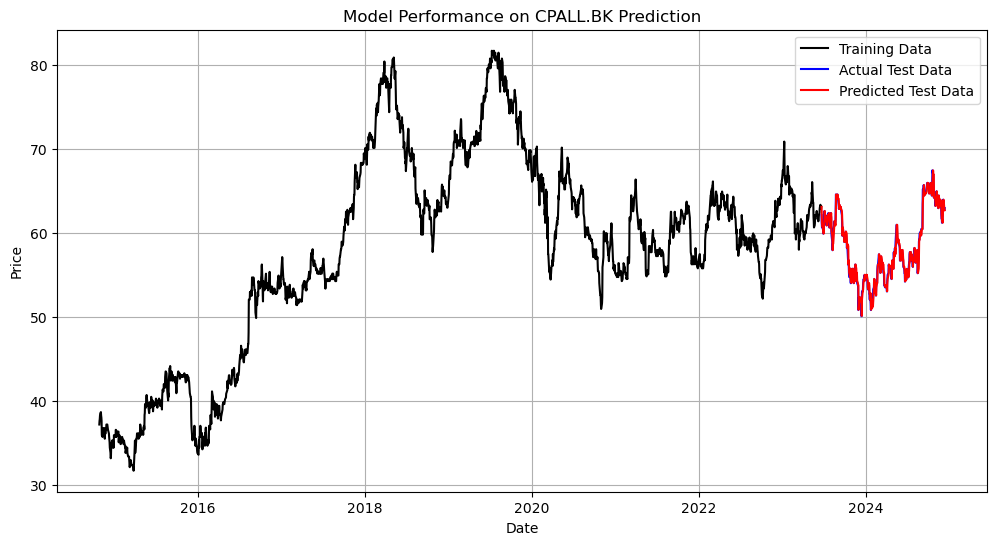


Starting prediction for stock: CPF.BK
Training set shape for CPF.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for CPF.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for CPF.BK: {'alpha': 0.01}
Performance for CPF.BK - RMSE: 0.31


<Figure size 640x480 with 0 Axes>

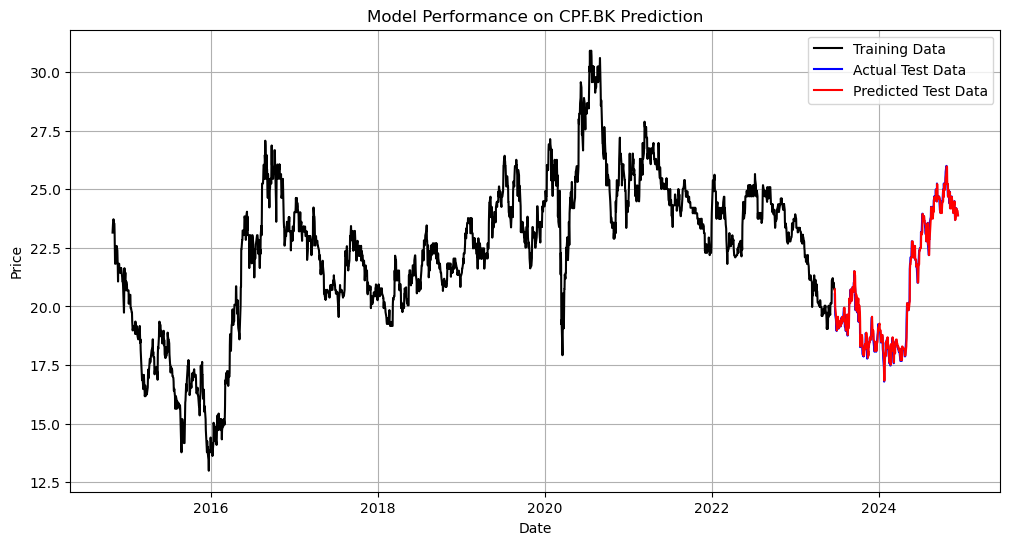


Starting prediction for stock: CPN.BK
Training set shape for CPN.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for CPN.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for CPN.BK: {'alpha': 0.01}
Performance for CPN.BK - RMSE: 0.92


<Figure size 640x480 with 0 Axes>

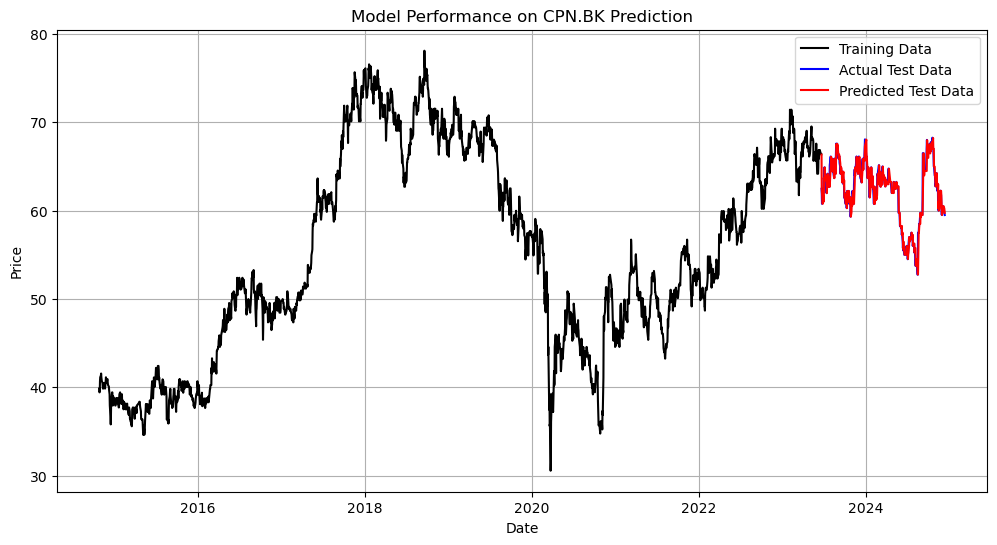


Starting prediction for stock: DELTA.BK
Training set shape for DELTA.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for DELTA.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for DELTA.BK: {'alpha': 0.01}
Performance for DELTA.BK - RMSE: 3.08


<Figure size 640x480 with 0 Axes>

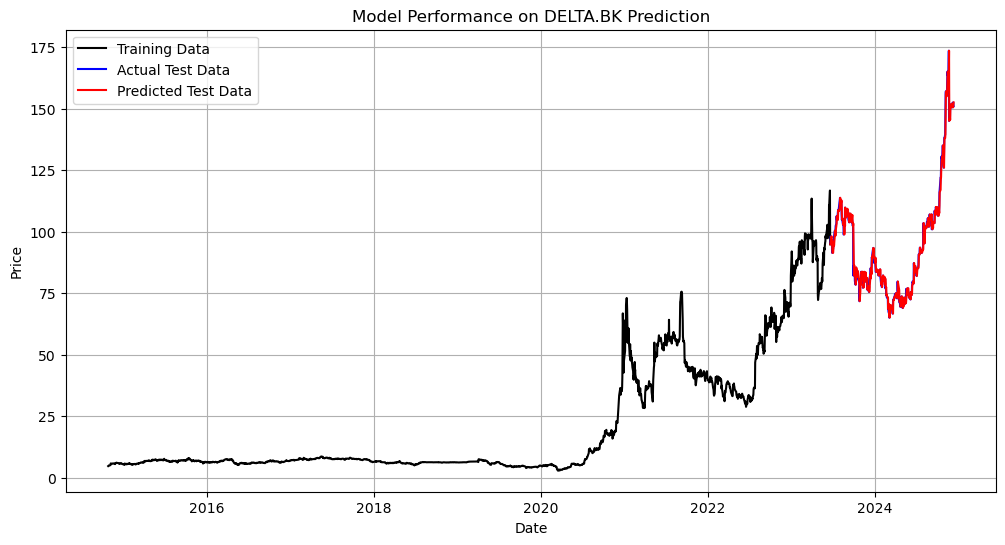


Starting prediction for stock: INTUCH.BK
Training set shape for INTUCH.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for INTUCH.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for INTUCH.BK: {'alpha': 0.01}
Performance for INTUCH.BK - RMSE: 1.23


<Figure size 640x480 with 0 Axes>

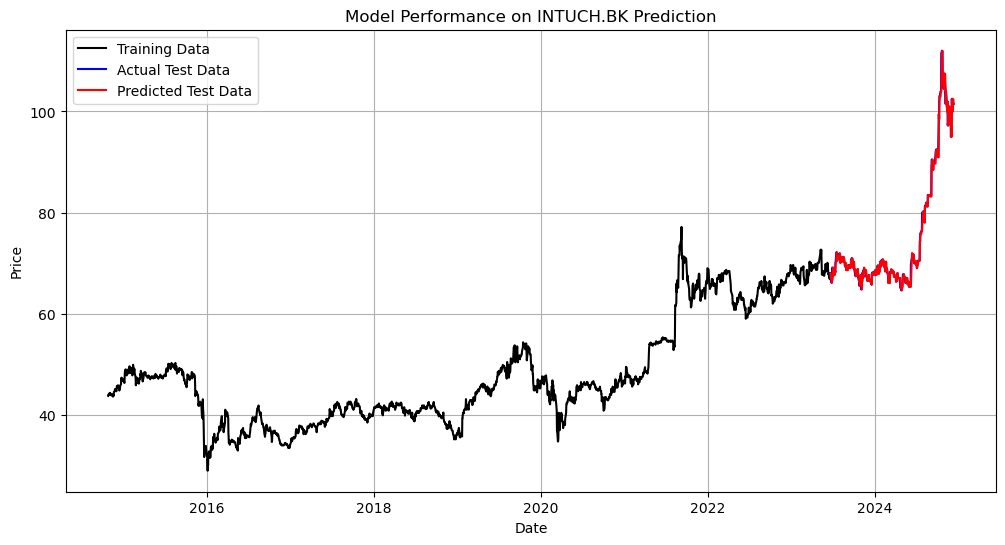


Starting prediction for stock: IVL.BK
Training set shape for IVL.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for IVL.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for IVL.BK: {'alpha': 0.01}
Performance for IVL.BK - RMSE: 0.57


<Figure size 640x480 with 0 Axes>

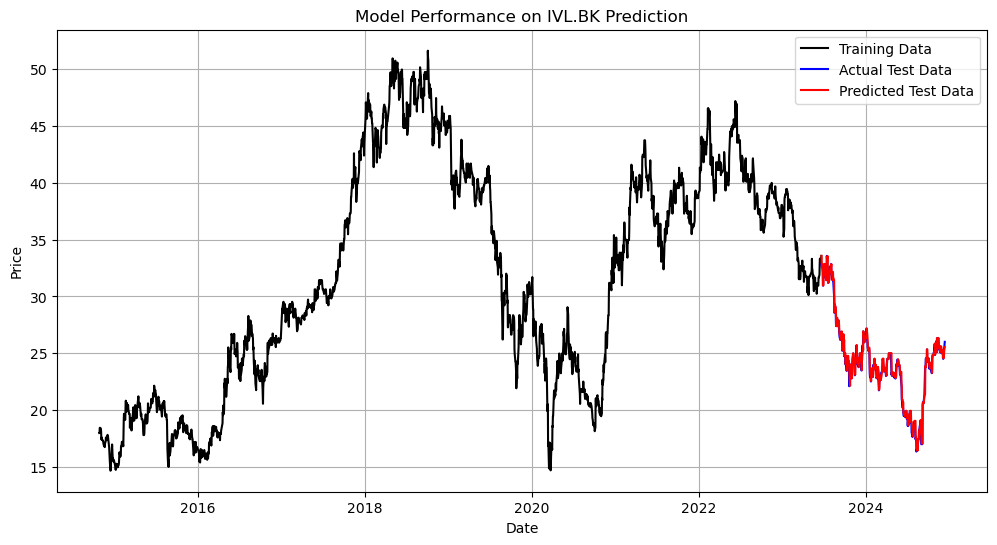


Starting prediction for stock: KBANK.BK
Training set shape for KBANK.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for KBANK.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for KBANK.BK: {'alpha': 0.01}
Performance for KBANK.BK - RMSE: 1.48


<Figure size 640x480 with 0 Axes>

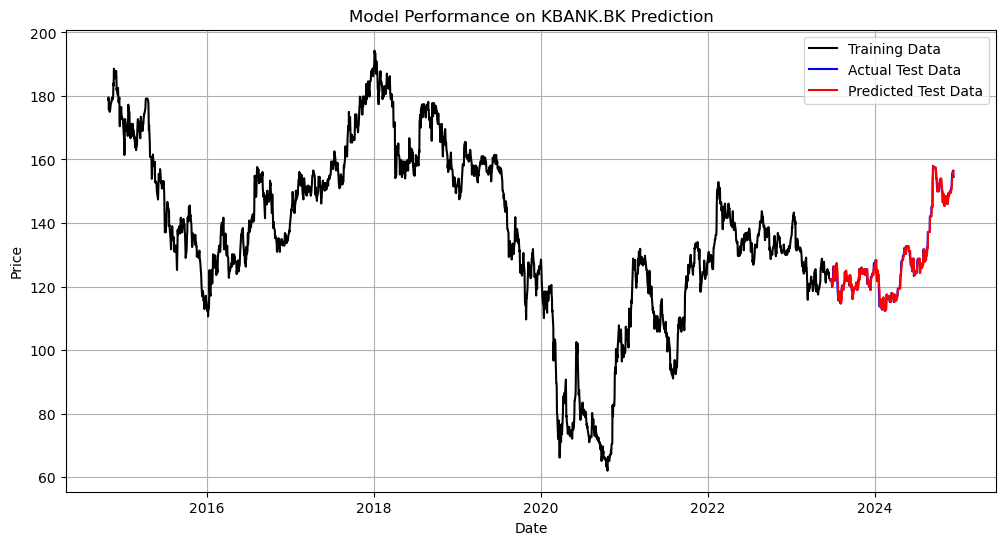


Starting prediction for stock: KTB.BK
Training set shape for KTB.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for KTB.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for KTB.BK: {'alpha': 0.01}
Performance for KTB.BK - RMSE: 0.23


<Figure size 640x480 with 0 Axes>

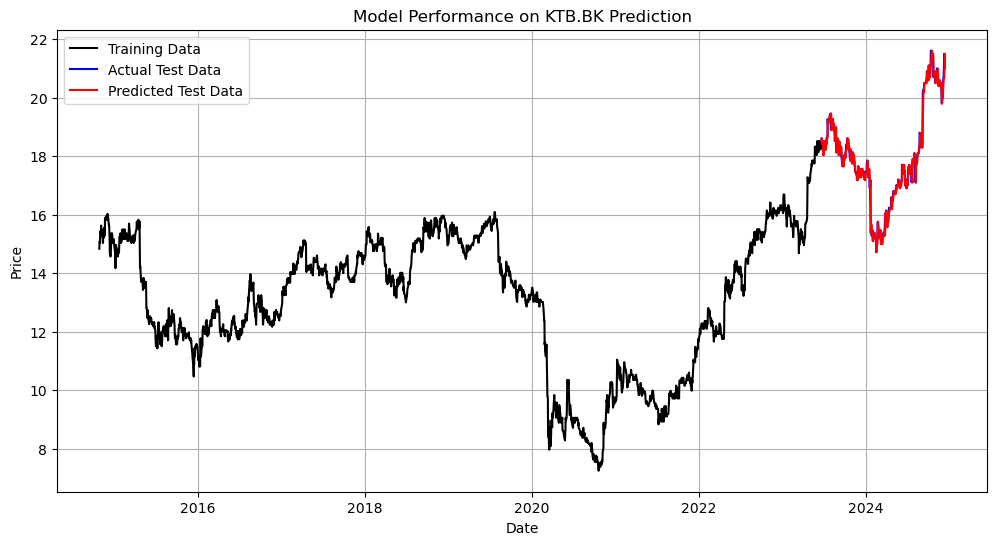


Starting prediction for stock: MINT.BK
Training set shape for MINT.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for MINT.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for MINT.BK: {'alpha': 0.01}
Performance for MINT.BK - RMSE: 0.47


<Figure size 640x480 with 0 Axes>

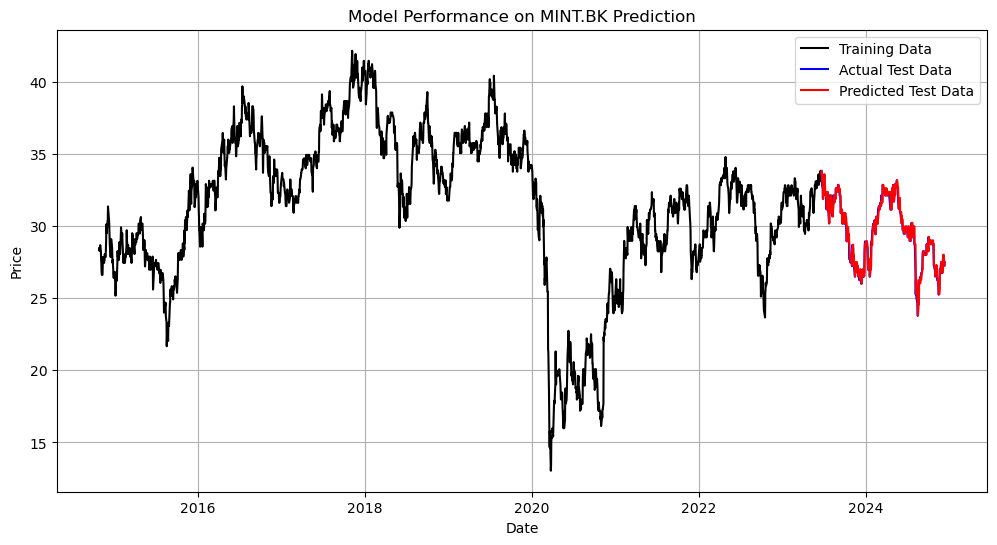


Starting prediction for stock: PTT.BK
Training set shape for PTT.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for PTT.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for PTT.BK: {'alpha': 0.01}
Performance for PTT.BK - RMSE: 0.34


<Figure size 640x480 with 0 Axes>

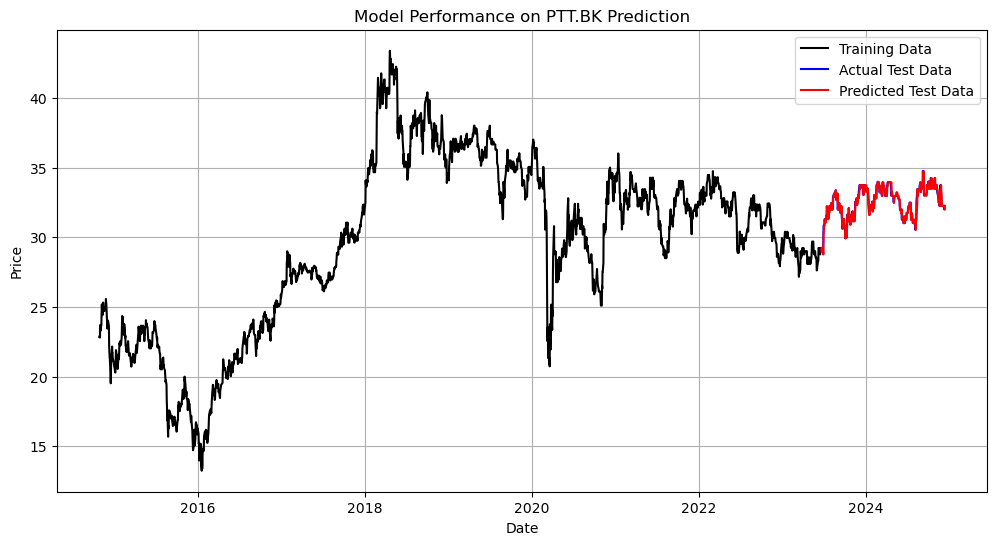


Starting prediction for stock: PTTEP.BK
Training set shape for PTTEP.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for PTTEP.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for PTTEP.BK: {'alpha': 0.01}
Performance for PTTEP.BK - RMSE: 1.84


<Figure size 640x480 with 0 Axes>

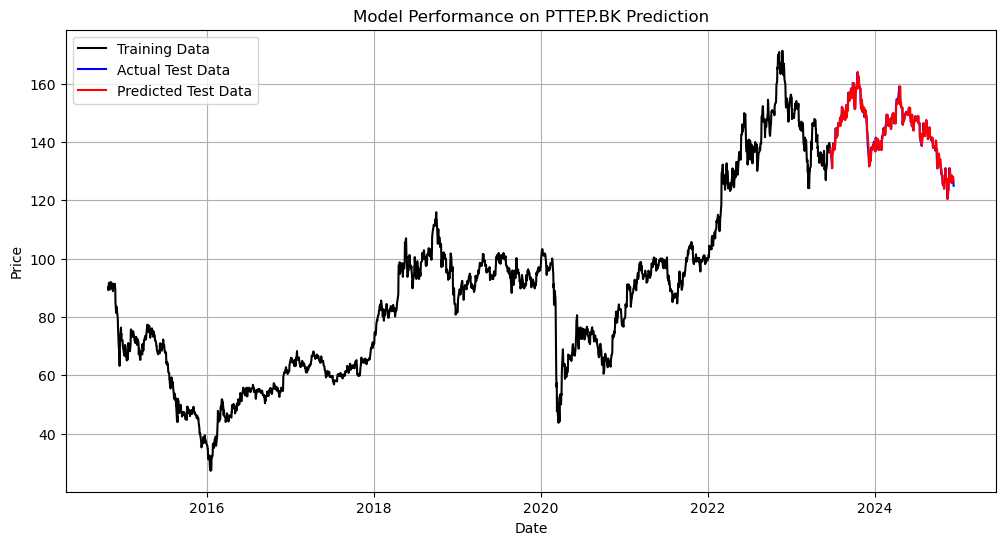


Starting prediction for stock: SCC.BK
Training set shape for SCC.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for SCC.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for SCC.BK: {'alpha': 0.01}
Performance for SCC.BK - RMSE: 3.67


<Figure size 640x480 with 0 Axes>

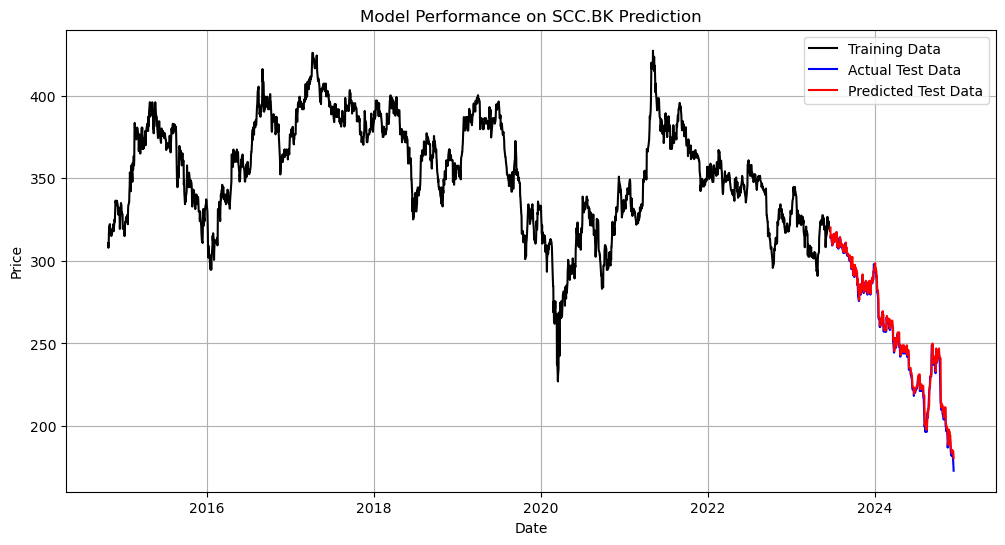


Starting prediction for stock: TRUE.BK
Training set shape for TRUE.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for TRUE.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for TRUE.BK: {'alpha': 0.01}
Performance for TRUE.BK - RMSE: 0.16


<Figure size 640x480 with 0 Axes>

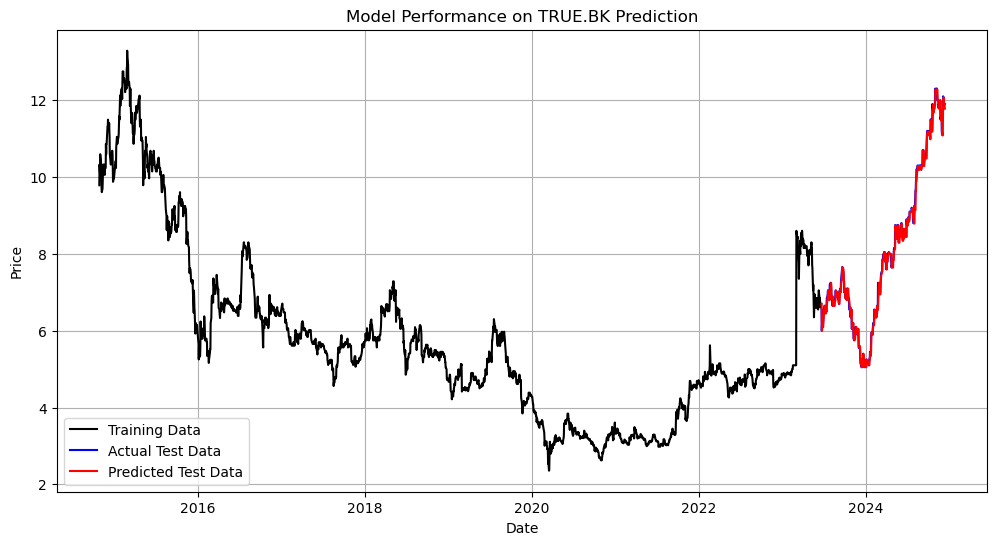


Starting prediction for stock: TTB.BK
Training set shape for TTB.BK: X_train: (2102, 1), y_train: (2102,)
Testing set shape for TTB.BK: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for TTB.BK: {'alpha': 0.01}
Performance for TTB.BK - RMSE: 0.02


<Figure size 640x480 with 0 Axes>

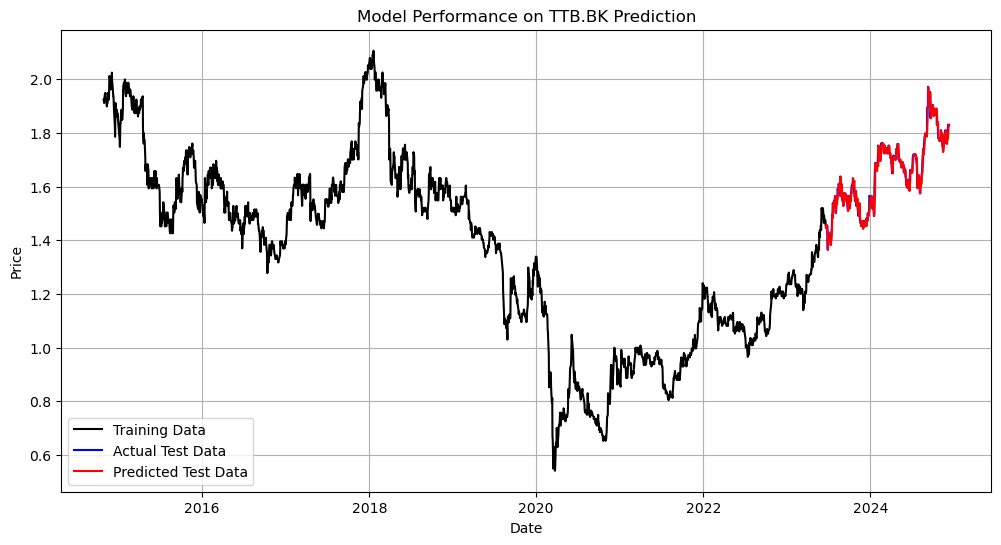


Summary of Results:
ADVANC.BK: RMSE = 2.80
AOT.BK: RMSE = 0.72
BBL.BK: RMSE = 1.59
BDMS.BK: RMSE = 0.37
BH.BK: RMSE = 3.98
CPALL.BK: RMSE = 0.75
CPF.BK: RMSE = 0.31
CPN.BK: RMSE = 0.92
DELTA.BK: RMSE = 3.08
INTUCH.BK: RMSE = 1.23
IVL.BK: RMSE = 0.57
KBANK.BK: RMSE = 1.48
KTB.BK: RMSE = 0.23
MINT.BK: RMSE = 0.47
PTT.BK: RMSE = 0.34
PTTEP.BK: RMSE = 1.84
SCC.BK: RMSE = 3.67
TRUE.BK: RMSE = 0.16
TTB.BK: RMSE = 0.02


<Figure size 640x480 with 0 Axes>

In [146]:
# Initialize dictionaries to store results
results = {}

# Define the hyperparameter grid for GridSearchCV (alpha for regularization strength)
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]  # Regularization strength
}

# Fixed test size for the last 360 rows
test_size = 360

# Time Series Split for cross-validation (preserves order)
tscv = TimeSeriesSplit(n_splits=3)

# Define folder for saving plots
output_folder = "ridge_predictions"
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# Loop through each stock in the set DataFrame
for stock in set.columns:

        print(f"\nStarting prediction for stock: {stock}")
        
        # Prepare the target (stock price) for each stock
        y_stock = set[stock]  # Stock price for this particular stock
        
        # Create univariate features: lagged price
        y_shifted = y_stock.shift(1).dropna()
        y_stock = y_stock.iloc[1:]

        # Define training and testing sets
        X_train = y_shifted[:-test_size].values.reshape(-1, 1)
        X_test = y_shifted[-test_size:].values.reshape(-1, 1)
        y_train = y_stock[:-test_size]
        y_test = y_stock[-test_size:]
        
        # Print dataset shapes
        print(f"Training set shape for {stock}: X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"Testing set shape for {stock}: X_test: {X_test.shape}, y_test: {y_test.shape}")
        
        # Initialize Ridge Regression model
        ridge_reg = Ridge()

        # Perform Grid Search with TimeSeriesSplit cross-validation
        grid_search = GridSearchCV(
            estimator=ridge_reg, 
            param_grid=param_grid, 
            cv=tscv, 
            scoring='neg_mean_squared_error', 
            verbose=1
        )
        
        # Fit the GridSearchCV model to the training data
        grid_search.fit(X_train, y_train)
        
        # Get the best hyperparameters from the grid search
        best_params = grid_search.best_params_
        print(f"Best Hyperparameters for {stock}: {best_params}")
        
        # Use the best estimator found by GridSearchCV to make predictions
        best_model = grid_search.best_estimator_
        
        # Make predictions on the test data
        y_pred = best_model.predict(X_test)
        
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        print(f"Performance for {stock} - RMSE: {rmse:.2f}")
        
        # Store the results (model, predictions, evaluation metrics)
        results[stock] = {
            'model': best_model, 
            'predictions': y_pred,
            'mse': mse,
            'rmse': rmse
        }
        
        # Combine training and testing actual prices for visualization
        plt.figure(figsize=(12, 6))
        
        # Plot training data (black)
        plt.plot(y_stock.index[:-test_size], y_stock.values[:-test_size], color='black', label='Training Data')
        
        # Plot actual test data (blue)
        plt.plot(y_stock.index[-test_size:], y_stock.values[-test_size:], color='blue', label='Actual Test Data')
        
        # Overlay the predicted prices for the test set (red)
        plt.plot(y_test.index, y_pred, color='red', label='Predicted Test Data')
        
        # Add title and labels
        plt.title(f'Model Performance on {stock} Prediction')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid()
        
        # Display the plot
        plt.show()
        
        # Save the plot
        plt.savefig(f'../images/{stock}_ridge_prediction_uni.png', format='png')


# Final summary of results
print("\nSummary of Results:")
for stock, metrics in results.items():
    print(f"{stock}: RMSE = {metrics['rmse']:.2f}")